In [2]:
import os
import cv2
from PIL import Image
import pickle
import torch
import torch.nn as nn
import numpy as np
from model import VPTEncoder, Controller, VPTCNNEncoder, IntraSituationCA
from memory import SituationLoader, Memory
from matplotlib import pyplot as plt
from scipy.spatial.distance import euclidean

from openai_vpt.lib.action_mapping import CameraHierarchicalMapping
from openai_vpt.lib.actions import ActionTransformer
from action_utils import ActionProcessor

from openai_vpt.lib.policy import MinecraftPolicy, VPTCNN, VPTRecurrence
from openai_vpt.lib.action_head import make_action_head

In [11]:
in_model = "data/VPT-models/foundation-model-1x.model"
in_weights = "data/VPT-models/foundation-model-3x.weights"
cnn_weights = "data/VPT-models/foundation-model-1x-cnn.weights"
trf_weights = "data/VPT-models/foundation-model-3x-trf.weights"

In [ ]:
# state = torch.load(in_weights, map_location="cpu")
# # keep weights only for the net part
# state = {k: v for k, v in state.items() if k.startswith("net.img_process")}
# # remove the "net." prefix
# prefix = len('net.')
# state = {k[prefix:]: v for k, v in state.items()}
# torch.save(state, "data/VPT-models/foundation-model-3x-cnn.weights")

In [12]:
vpt = VPTCNNEncoder(in_model, cnn_weights)
vpt.eval()
expert_dataloader = SituationLoader(vpt, data_dir="data/MakeWaterfallTrain/")

In [13]:
demonstrations = expert_dataloader.load_demonstrations(num_demos=1)

Loading expert demonstrations:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
encoded_demos = expert_dataloader.encode_demonstrations(demonstrations)

In [ ]:
situations = expert_dataloader.create_situations(encoded_demos, stride=64)

In [14]:
class Retriever:
    def __init__(self, encoder_model, encoder_weights, memory_path):
        self.vpt = VPTCNNEncoder(encoder_model, encoder_weights)
        self.vpt.eval()
        self.memory = Memory()
        self.memory.load_index(memory_path)

    def encode_query(self, query_obs):
        return self.vpt(query_obs).squeeze().cpu().numpy()

    def retrieve(self, query_obs, k=1, encode_obs=True):
        if encode_obs:
            query_obs = self.encode_query(query_obs)
        results = self.memory.search(query_obs, k=k)
        
        return results[0], query_obs

In [15]:
retriever = Retriever(in_model, in_weights, "data/memory_cnn.json")

In [16]:
def _load_video(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (128, 128), interpolation=cv2.INTER_LINEAR)
        frames.append(frame)
    cap.release()
    return frames

def load_demonstration(demo_id, root_dir="data/MakeWaterfallDB"):
    video_path = f"{root_dir}/{demo_id}.mp4"
    frames = _load_video(video_path)
    return frames

def load_situation(situation_id, demo_frames):
    situation = demo_frames[situation_id]
    return situation

547.12714


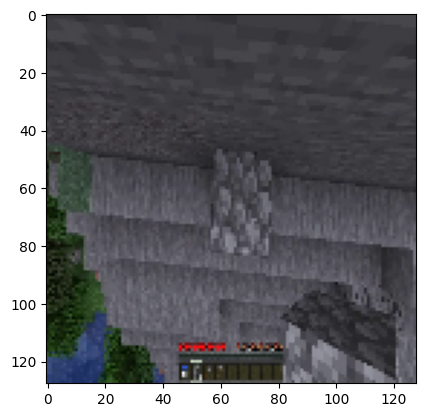

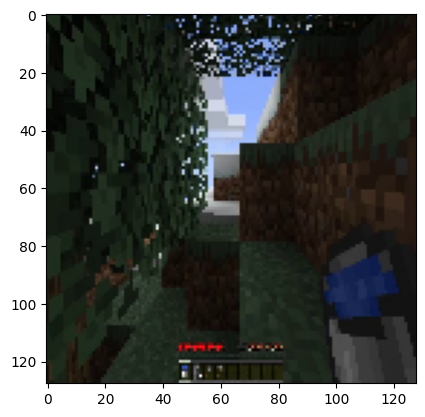

: 

In [17]:
idx = 430
for obs in demonstrations[0]['video'][idx:idx+1]:
    result, query_obs_vec = retriever.retrieve(obs)
    print(result['distance'])
    plt.imshow(obs[..., ::-1])
    plt.show()
    res_demo = load_demonstration(result['demo_id'], root_dir="data/MakeWaterfallDB")
    res_situation = load_situation(result['sit_frame_idx'], res_demo)
    plt.imshow(res_situation[..., ::-1])
    plt.show()

In [18]:
class Controller(nn.Module):
    """Applies Cross Attention on the observation embedding with the situation embeddings and the next action"""

    def __init__(self, vpt_model):
        super().__init__()

        # Define some constants
        d_model = 1024  # dimension of the input and output vectors
        d_k = 1024  # dimension of the query and key vectors
        d_v = 1024  # dimension of the value vectors
        n_heads = 4  # number of attention heads
        assert d_model % n_heads == 0  # make sure d_model is divisible by n_heads

        self.intra_situation_ca = IntraSituationCA()

        # Define linear layers for projection
        self.Wq_obs = nn.Linear(1024, d_model)  # project observation embedding to query vector
        self.Wk_sit = nn.Linear(1024, d_k)  # project situation embedding to key vector
        self.Wv_sit = nn.Linear(1024, d_v)  # project situation embedding to value vector
        self.Wk_next_key = nn.Linear(8641, d_k)  # project next keyboard action one-hot vector to key vector
        self.Wv_next_key = nn.Linear(8641, d_v)  # project next keyboard action one-hot vector to value vector
        self.Wk_next_cam = nn.Linear(121, d_k)  # project next camera action one-hot vector to key vector
        self.Wv_next_cam = nn.Linear(121, d_v)  # project next camera action one-hot vector to value vector

        # Define multi-head attention layer
        self.cross_attention = nn.MultiheadAttention(d_model, n_heads)

        # TODO: Dynamic scaling factor for cross-attention importance
        # TODO: condition on distance between observation and situation
        # self.alpha_head = nn.Linear(d_model, 1)
        # self.alpha = nn.Parameter(torch.tensor(0.5))
        self.alpha = 1.0

        # Define output layer for concatenation or addition
        self.Wo = nn.Linear(d_v, d_model)  # project output vector to original dimension

        # Define VPT Transformer layers
        self.vpt_transformers = VPTRecurrence(**self.load_vpt_parameters(vpt_model))
        self.dummy_first = torch.from_numpy(np.array((False,))).unsqueeze(1)

    def forward(self, observation, situation, situation_actions, next_action, state_in):
        
        # Apply intra-situation cross attention
        situation = self.intra_situation_ca(situation, situation_actions)

        # Project input tensors to query, key and value vectors
        q_obs = self.Wq_obs(observation)  # query vector tensor of shape [1, 1, 1024]
        k_sit = self.Wk_sit(situation)  # key vector tensor of shape [1, 1, 1024]
        v_sit = self.Wv_sit(situation)  # value vector tensor of shape [1, 1, 1024]
        k_key = self.Wk_next_key(next_action['buttons'])  # key vector tensor of shape [1, 1, 1024]
        v_key = self.Wv_next_key(next_action['buttons'])  # value vector tensor of shape [1, 1, 1024]
        k_cam = self.Wk_next_cam(next_action['camera'])  # key vector tensor of shape [1, 1, 1024]
        v_cam = self.Wv_next_cam(next_action['camera'])  # value vector tensor of shape [1, 1, 1024]

        # Concatenate all the key and value vectors along the second dimension
        key_vec = torch.cat([k_sit, k_key, k_cam], dim=1)  # key vector tensor of shape [1, 3, 1024]
        val_vec = torch.cat([v_sit, v_key, v_cam], dim=1)  # value vector tensor of shape [1, 3, 1024]

        # Apply multi-head attention on the query and key-value pairs
        out_obs, _ = self.cross_attention(q_obs, key_vec.transpose(0, 1), val_vec.transpose(0, 1))

        # Add the output vector with the original query vector
        # alpha = torch.sigmoid(self.alpha_head(observation)).squeeze()
        out_obs = q_obs + (out_obs * self.alpha)

        # Apply output layer on the output vector
        out_obs = self.Wo(out_obs)

        # Apply VPT Transformer
        latent, state_out = self.vpt_transformers(out_obs, state_in, self.dummy_first)

        return latent, state_out

    def initial_state(self, batch_size):
        return self.vpt_transformers.initial_state(batch_size)

    def load_vpt_parameters(self, model_path):
        """Load model parameters from model_path"""

        with open(model_path, "rb") as f:
            agent_parameters = pickle.load(f)
            policy_kwargs = agent_parameters["model"]["args"]["net"]["args"]

            return policy_kwargs

In [24]:
def one_hot_encode(actions: list, num_classes: int, add_batch_dim: bool = True):
    '''One-hot encodes the actions'''
    actions = torch.tensor(actions)
    if add_batch_dim:
        actions = actions.unsqueeze(0)
    return torch.nn.functional.one_hot(actions, num_classes=num_classes).float()

def preprocess_situation(situation, device='cuda'):
    retrieved_situation = torch.Tensor(situation['embedding']).to(device).reshape(1, 1, -1)
    retrieved_actions = {
        "camera": one_hot_encode(situation['situation_actions']['camera'], 121).to(device),
        "buttons": one_hot_encode(situation['situation_actions']['buttons'], 8641).to(device)
    }

    # print(len(situation['situation_actions']['camera']), len(situation['situation_actions']['buttons']))
    
    next_action = {
        "camera": one_hot_encode(situation['next_action']['camera'], 121).to(device),
        "buttons": one_hot_encode(situation['next_action']['buttons'], 8641).to(device)
    }

    return retrieved_situation, retrieved_actions, next_action

In [20]:
controller = Controller(in_model).to('cuda')

In [21]:
controller.vpt_transformers.load_state_dict(torch.load(trf_weights, map_location=torch.device('cuda')))

<All keys matched successfully>

In [25]:
obs = demonstrations[0]['video'][idx]

In [26]:
obs_vector = vpt(obs)
situation, _ = retriever.retrieve(obs_vector.to('cpu'), k=1, encode_obs=False)
situation_embed, situation_actions, next_action = preprocess_situation(situation)
state = controller.initial_state(1)
latent, state = controller(obs_vector.to('cuda'), situation_embed, situation_actions, next_action, state)

In [27]:
latent.shape

torch.Size([1, 1, 1024])

In [28]:
from openai_vpt.lib.action_mapping import CameraHierarchicalMapping
from openai_vpt.lib.actions import ActionTransformer
from openai_vpt.lib.torch_util import default_device_type, set_default_torch_device
from openai_vpt.lib.action_head import make_action_head
from gym3.types import DictType

In [29]:
def load_model_parameters(path_to_model_file):
    agent_parameters = pickle.load(open(path_to_model_file, "rb"))
    policy_kwargs = agent_parameters["model"]["args"]["net"]["args"]
    pi_head_kwargs = agent_parameters["model"]["args"]["pi_head_opts"]
    pi_head_kwargs["temperature"] = float(pi_head_kwargs["temperature"])
    return policy_kwargs, pi_head_kwargs

In [44]:
agent_policy_kwargs, agent_pi_head_kwargs = load_model_parameters(in_model.replace('1x', '3x'))

In [34]:
# Set the default torch device for underlying code as well
set_default_torch_device('cuda')
action_mapper = CameraHierarchicalMapping(n_camera_bins=11)
action_space = action_mapper.get_action_space_update()
action_space = DictType(**action_space)

In [40]:
action_head = make_action_head(action_space, 1024, **agent_pi_head_kwargs).to('cuda')

In [46]:
output = action_head(latent)

: 

In [83]:
class REBECA(nn.Module):
    def __init__(self, vpt_model, cnn_weights, trf_weights, memory_path, device='auto'):
        super().__init__()

        if device == 'auto':
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        self.retriever = Retriever(vpt_model, cnn_weights, memory_path)
        self.vpt_cnn = VPTCNNEncoder(vpt_model, cnn_weights)
        self.vpt_cnn.eval()

        self.controller = Controller(vpt_model)
        if trf_weights:
            self.controller.vpt_transformers.load_state_dict(torch.load(trf_weights, map_location=torch.device('cuda')))

        # Action processing
        set_default_torch_device(self.device)
        self.action_mapper = CameraHierarchicalMapping(n_camera_bins=11)
        action_space = self.action_mapper.get_action_space_update()
        action_space = DictType(**action_space)
        self.action_transformer = ActionTransformer(**ACTION_TRANSFORMER_KWARGS)

        # Action Head
        self.action_head = make_action_head(action_space, 1024, temperature=1.0).to('cuda')

    def forward(self, obs, state_in):
        
        # extract features from observation
        obs_feats = self.vpt_cnn(obs)

        # retrieve situation from memory
        situation, _ = self.retriever.retrieve(obs_feats.to('cpu'), k=1, encode_obs=False)

        # process retrieved situations
        situation_embed, situation_actions, next_action = preprocess_situation(situation, self.device)
        
        # forward pass through controller
        action_logits, state_out = self.controller(obs_feats, situation_embed, situation_actions, next_action, state_in)

        return action_logits, state_out

    def _env_action_to_agent(self, minerl_action_transformed, to_torch=False, check_if_null=False):
        """
        Turn action from MineRL to model's action.

        Note that this will add batch dimensions to the action.
        Returns numpy arrays, unless `to_torch` is True, in which case it returns torch tensors.

        If `check_if_null` is True, check if the action is null (no action) after the initial
        transformation. This matches the behaviour done in OpenAI's VPT work.
        If action is null, return "None" instead
        """
        minerl_action = self.action_transformer.env2policy(minerl_action_transformed)
        if check_if_null:
            if np.all(minerl_action["buttons"] == 0) and np.all(minerl_action["camera"] == self.action_transformer.camera_zero_bin):
                return None

        # Add batch dims if not existant
        if minerl_action["camera"].ndim == 1:
            minerl_action = {k: v[None] for k, v in minerl_action.items()}
        action = self.action_mapper.from_factored(minerl_action)
        if to_torch:
            action = {k: torch.from_numpy(v).to(self.device) for k, v in action.items()}
        return action

In [85]:
rebeca = REBECA(in_model, cnn_weights, trf_weights, "data/memory_cnn.json", device='cuda').to('cuda')

In [88]:
state = rebeca.controller.initial_state(1)
for frame in demonstrations[0]['video'][0:1]:
    actions, state = rebeca(frame, state)

In [91]:
actions['buttons'].argmax().item(), actions['camera'].argmax().item()

(7819, 73)